# Set Required Args to Activate Modules

In [1]:
# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #'wind','solar'
countries=['AL'] #'AL, 'BA','XK','ME','MK','RS']

In [2]:
import RES.RESources as RES

for country in countries:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "region_short_code": country,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)

2025-06-25 09:18:48,090 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-25 09:18:48,091 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.
2025-06-25 09:18:48,259 - INFO - ATB cost datafile: ATBe.parquet loaded
2025-06-25 09:18:48,499 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-25 09:18:48,500 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/wind'


2025-06-25 09:18:48,698 - INFO - ATB cost datafile: ATBe.parquet loaded


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/wind'


# --------------- stepwise data checks STARTS here

In [3]:
# data1=RES_module.get_grid_cells()

In [4]:
# data2=RES_module.get_cell_capacity()

In [ ]:
data3=RES_module.get_CF_timeseries()

In [6]:
# data4=RES_module.extract_weather_data()

In [ ]:
# data5=RES_module.update_gwa_scaled_params(False)

In [8]:
# data6=RES_module.find_grid_nodes(use_pypsa_buses=False)

In [9]:
# data7= RES_module.score_cells()

In [10]:
# data8= RES_module.get_clusters()

In [11]:
# data9= RES_module.get_cluster_timeseries()

# --------------- stepwise data checks ENDS here

# Store

In [12]:
from RES.hdf5_handler import DataHandler
store=f"data/store/resources_{countries[0]}.h5"
res_data=DataHandler(store)

In [13]:
cells=res_data.from_store('cells')
boundary=res_data.from_store('boundary')
lines=res_data.from_store('lines')
solar_clusters=res_data.from_store('clusters/solar')
wind_clusters=res_data.from_store('clusters/wind')
solar_clusters_ts=res_data.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_data.from_store('timeseries/clusters/wind')

In [28]:
cells.columns

Index(['y', 'x', 'potential_capacity_wind', 'capex_wind', 'fom_wind',
       'vom_wind', 'grid_connection_cost_per_km_wind',
       'tx_line_rebuild_cost_wind', 'Operational_life_wind', 'Country',
       'Region', 'geometry', 'wind_CF_mean', 'windspeed_ERA5', 'windspeed_gwa',
       'CF_IEC1', 'CF_IEC2', 'CF_IEC3', 'y_2', 'x_2', 'nearest_distance',
       'lcoe_wind', 'potential_capacity_solar', 'capex_solar', 'fom_solar',
       'vom_solar', 'grid_connection_cost_per_km_solar',
       'tx_line_rebuild_cost_solar', 'Operational_life_solar', 'solar_CF_mean',
       'lcoe_solar'],
      dtype='object')

<Axes: >

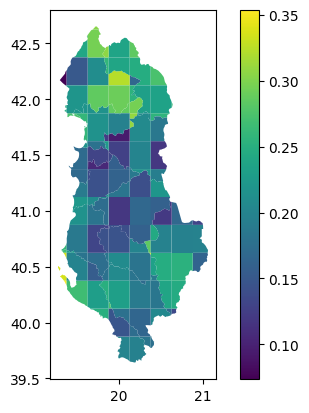

In [32]:
cells.plot('CF_IEC3',legend=True)

<Axes: >

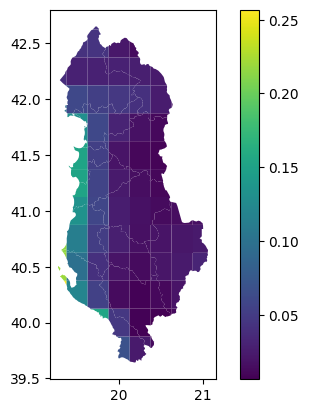

In [31]:
cells.plot('wind_CF_mean',legend=True)

<Axes: >

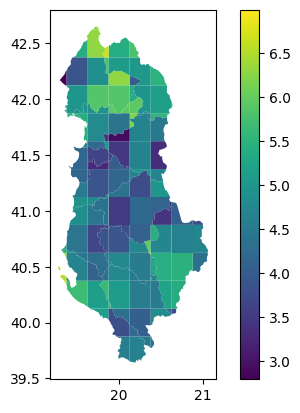

In [29]:
cells.plot('windspeed_gwa',legend=True)

In [15]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

>>> Selecting TOP Sites to for 10 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV
____________________________________________________________________________________________________
>>> Selecting TOP Sites to for 20 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW PV
____________________________________________________________________________________________________


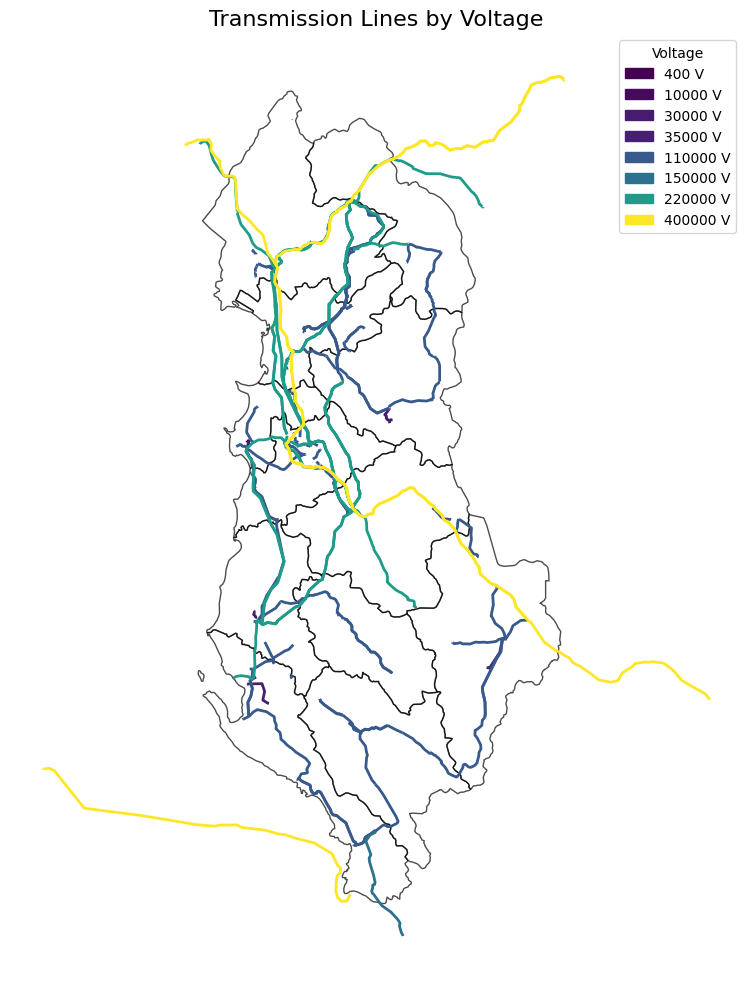

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7)

if 'voltage' in lines.columns:
    # Convert voltages to numeric, coerce errors to NaN, then drop NaN
    voltages = pd.to_numeric(lines['voltage'], errors='coerce').dropna().unique()
    voltages.sort()
    cmap = plt.cm.viridis
    norm = plt.Normalize(voltages.min(), voltages.max())
    colors = [cmap(norm(v)) for v in voltages]
    for v, color in zip(voltages, colors):
        lines[pd.to_numeric(lines['voltage'], errors='coerce') == v].plot(ax=ax, color=color, linewidth=2, label=str(int(v)))
    legend_patches = [mpatches.Patch(color=color, label=f"{int(v)} V") for v, color in zip(voltages, colors)]
    ax.legend(handles=legend_patches, title='Voltage')
    ax.set_title('Transmission Lines by Voltage', fontsize=16)
else:
    lines.plot(ax=ax, color='blue', linewidth=1)
    ax.set_title('Transmission Lines', fontsize=16)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
from RES.visuals import add_compass_to_plot

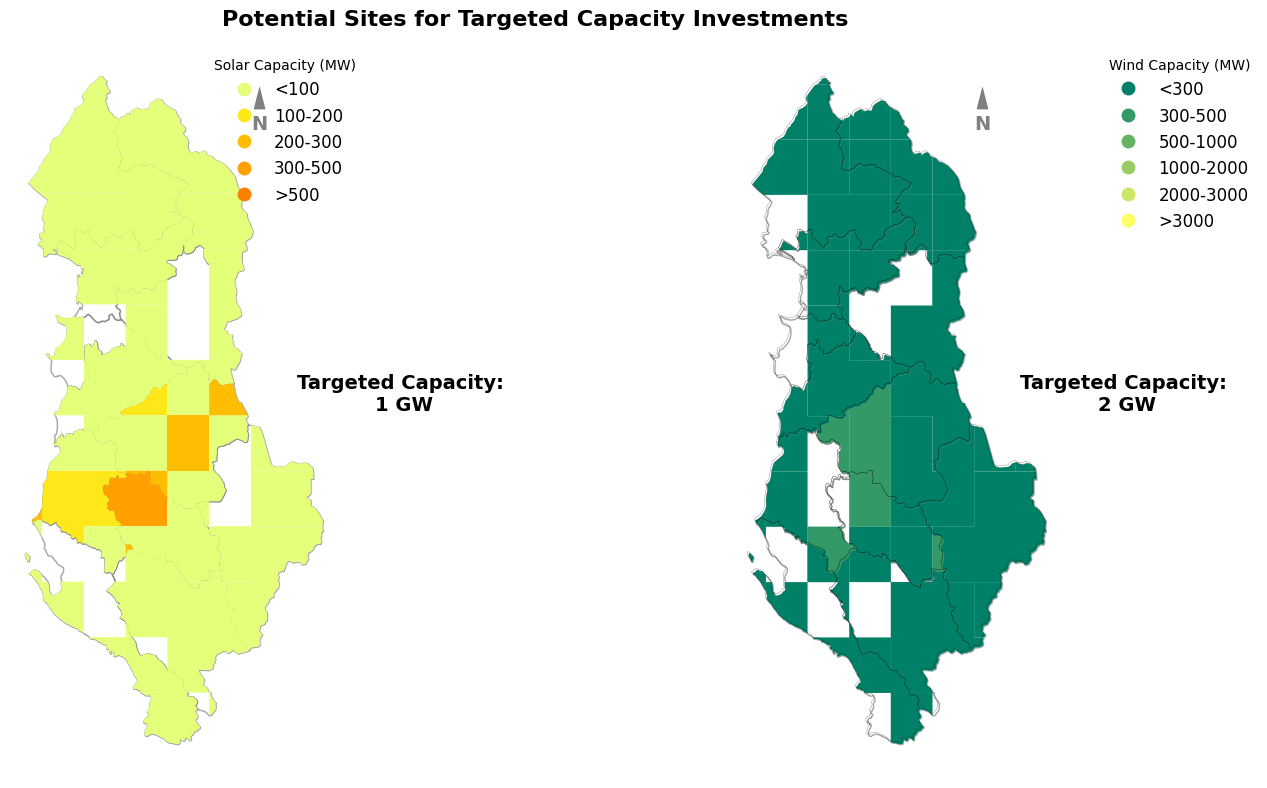

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1.1

# Ensure 'Region' is in the columns for both boundary and cells
# if boundary is not None and ('Region' not in boundary.columns or 'Country' not in boundary.columns):
#     boundary = boundary.reset_index()

# Assign a number to each region
# boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
# boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()


# Add annotation for solar capacity
ax1.annotate(f"Targeted Capacity: \n{int(resource_clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')

# Add annotation for wind capacity
ax2.annotate(f"Targeted Capacity: \n{int(resource_clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')
# Show the side-by-side plot

plt.savefig('vis/solar_wind_capacity_map.png',dpi=300)
# Add a directional compass (north arrow) to both subplots
# Use a more standard north arrow style
add_compass_to_plot(ax1)
add_compass_to_plot(ax2)
plt.show()

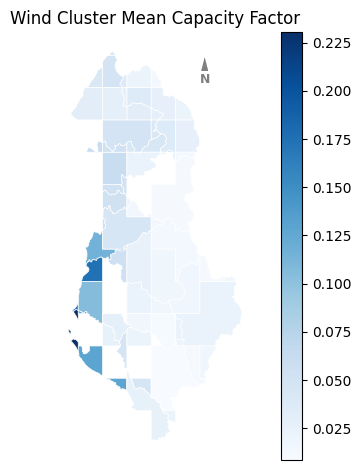

In [19]:
ax = wind_clusters.plot(column='CF_mean', cmap='Blues', legend=True, edgecolor='white', linewidth=0.5)
ax.set_title("Wind Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_to_plot(ax,size=9)
plt.tight_layout()
plt.show()

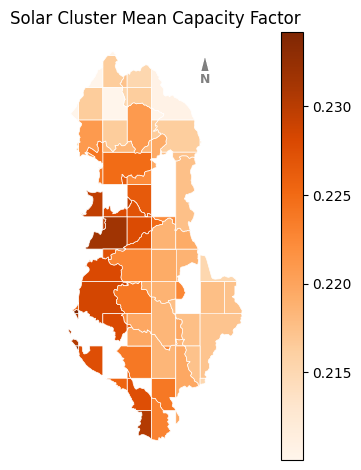

In [20]:
ax =solar_clusters.plot(column='CF_mean', cmap='Oranges', legend=True, edgecolor='white', linewidth=0.5)
ax.set_title("Solar Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_to_plot(ax,size=9)
plt.tight_layout()
plt.show()